## Introduction
Generally speaking, future market prices are unpredictable and almost random. But there is always a correlation between different assets, which is not random and probably can be used to get more accurate price evaluation, especially during crises and high volatility. In this kernel I will try to show that ML model after analysed the most influential historical data and grasped fundamental dependencies is capable enough to accurately detect anomalies in USD/RUB pricing. And based on Regression toward the mean phenomenon we can bet against those anomalies. Based on my knowledge and understanding of the markets the most significant assets to influence USD/RUB price are: government bonds, repo rates, oil, and stock indexes. Let's examine those dependencies first. 

In [ ]:
!pip install catboost sklearn shap

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from catboost import Pool
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, anneal, Trials

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

##  Read in the first 600 rows of market data, which are in our case the latest 600 trading days or almost two and a half years.

In [2]:
main_df = pd.read_csv('market_data.csv')
main_df.Date = pd.to_datetime(main_df.Date,yearfirst=True)
main_df

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_Repo,USD_RUB
0,2017-03-13,51.43,1.06545,36.708759,13023.33,8.34,18.135187,0.728,1.16,58.7725
1,2017-03-14,51.56,1.06000,36.499207,13016.08,8.33,17.879892,0.753,1.17,59.1600
2,2017-03-15,51.97,1.07255,37.451694,12957.17,8.28,18.426956,0.715,1.16,58.3900
3,2017-03-16,51.74,1.07675,37.680290,13093.18,8.22,18.627546,0.708,1.29,57.7900
4,2017-03-17,51.75,1.07360,37.613617,13247.03,8.21,19.046963,0.708,1.31,57.2200
...,...,...,...,...,...,...,...,...,...,...
596,2019-08-22,59.89,1.10800,39.639999,18186.19,7.15,22.080000,1.938,2.09,65.6000
597,2019-08-23,58.78,1.11348,39.049999,18058.85,7.15,21.740000,1.910,2.11,65.9850
598,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,2.10,66.0700
599,2019-08-27,58.70,1.10898,39.330002,17973.86,7.17,21.719999,1.943,2.09,66.4425


## Some basic exploratory Data Analysis (EDA)

In [3]:
main_df.describe()

,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_Repo,USD_RUB
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,64.323245,1.154990,42.371286,15155.645141,7.813045,20.260870,1.709245,2.213710,61.871676
std,9.372336,0.041284,2.822193,1861.955099,0.505143,1.500698,0.552593,0.593644,3.875063
min,44.770000,1.059250,36.499207,11762.240000,6.820000,16.566936,0.708000,1.000000,55.705000
25%,56.980000,1.125650,39.985130,13445.230000,7.400000,19.246469,1.083000,1.790000,57.900000
50%,64.270000,1.149840,42.365707,15191.330000,7.830000,20.159327,1.870000,2.310000,62.505000
75%,71.880000,1.179200,44.084286,16511.380000,8.200000,21.209999,2.258000,2.500000,65.490000
max,85.900000,1.251700,50.590469,19251.210000,9.100000,24.120001,2.408000,4.090000,70.565000


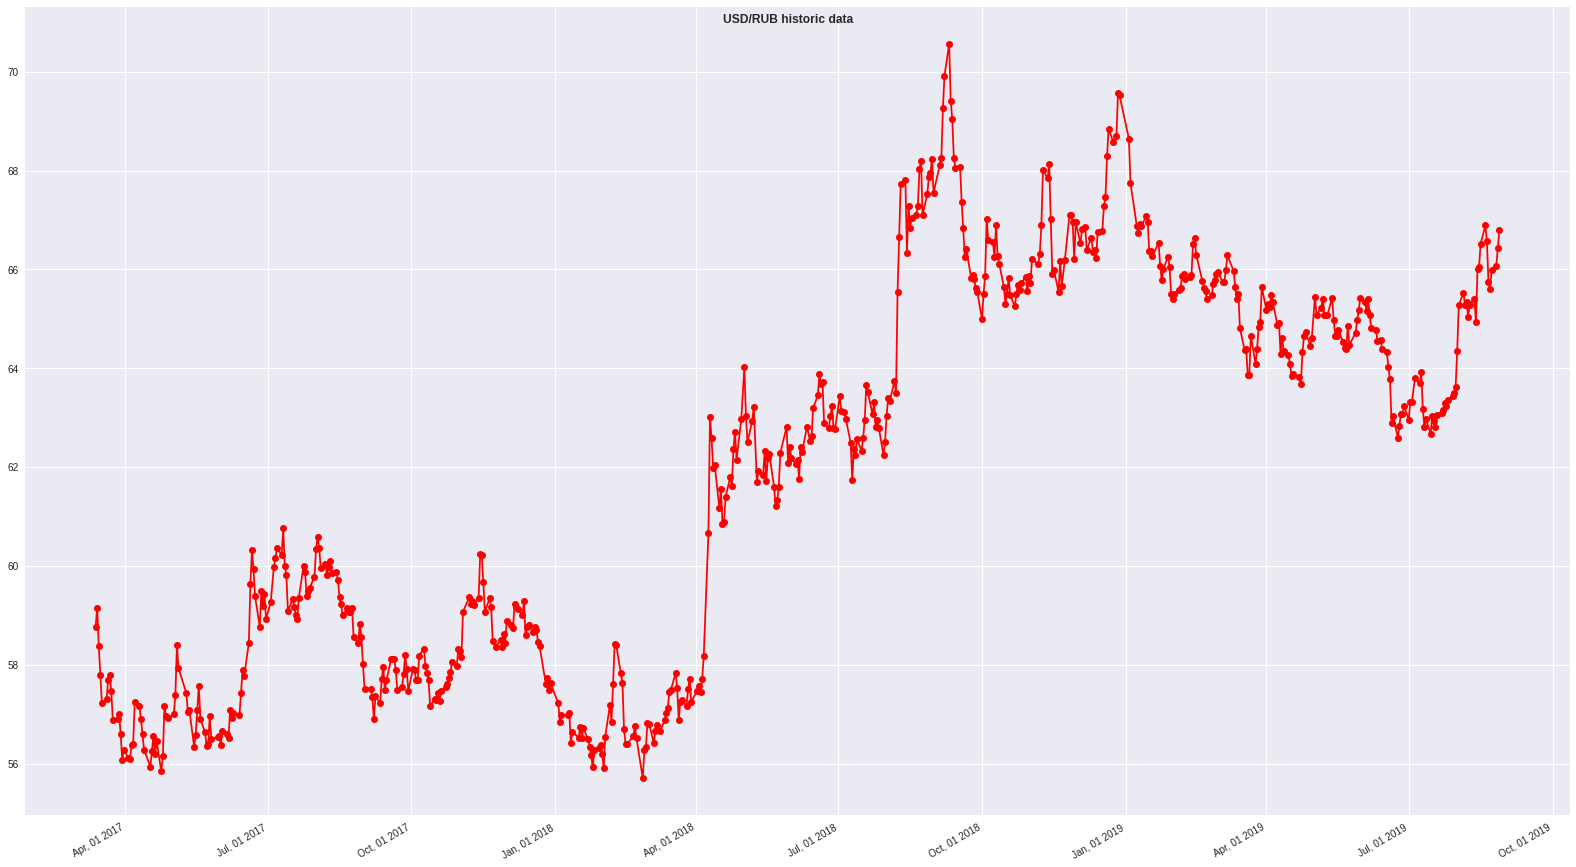

In [4]:
fig, axs = plt.subplots(figsize=(22,12))
fig.suptitle('USD/RUB historic data', fontweight ="bold")

plt.plot_date(main_df.Date, main_df.USD_RUB, color='red',  linestyle = 'solid')
plt.gcf().autofmt_xdate()

date_format = mpl_dates.DateFormatter('%b, %d %Y')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(date_format)

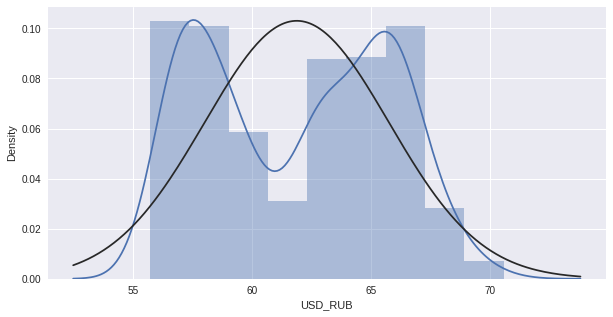

In [5]:
fig = plt.figure(figsize=(10,5))
sns.distplot(main_df['USD_RUB'], fit=norm)

Our target USD_RUB is not normally distributed thus making prediction modeling harder. Unfortunately log transformation won't help in this case.  Let's explore correlations between our target and features. 

In [6]:
main_df.drop('Date', 1, inplace=True)
corr_df= pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df.rename(columns={'USD_RUB': 'corr_original'}, inplace=True)
corr_df

,corr_original
USD_RUB,1.000000
Treas_4M,0.864866
MOEXBC,0.695755
USD_Repo,0.621623
RGBITR_YIELD,0.567899
Brent,0.474665
Emerging_Markets,0.331401
EUR_USD,0.296095
Russia_ETF,0.127072


As we can see correlation with bonds indexes, stock indexes, repo rates and oil prices are the strongest. Let's explore mutual information of features and target.

In [7]:
X = main_df.drop('USD_RUB', 1)
y =  main_df.USD_RUB

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores 

Treas_4M            1.185168
MOEXBC              1.183162
RGBITR_YIELD        1.043430
Russia_ETF          0.930255
Brent               0.915405
USD_Repo            0.899147
EUR_USD             0.858828
Emerging_Markets    0.786895
Name: MI Scores, dtype: float64

Surprisingly enough, all features exhibit a strong relationship with the target. Since nonlinear relationships are possible, mutual information scores are more important

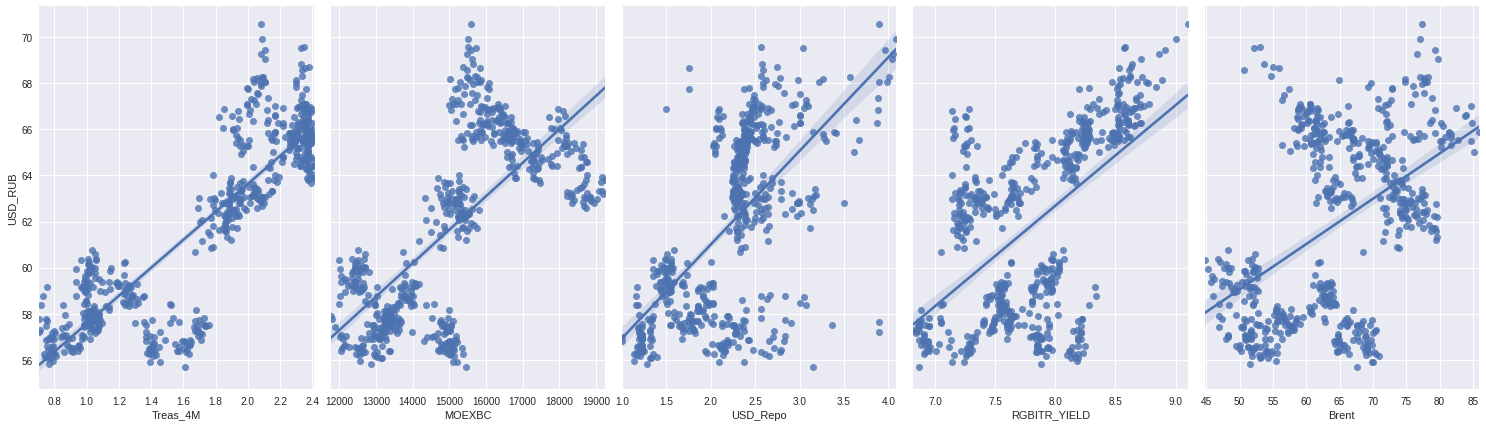

In [8]:
sns.pairplot(main_df, x_vars=['Treas_4M','MOEXBC','USD_Repo','RGBITR_YIELD','Brent'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

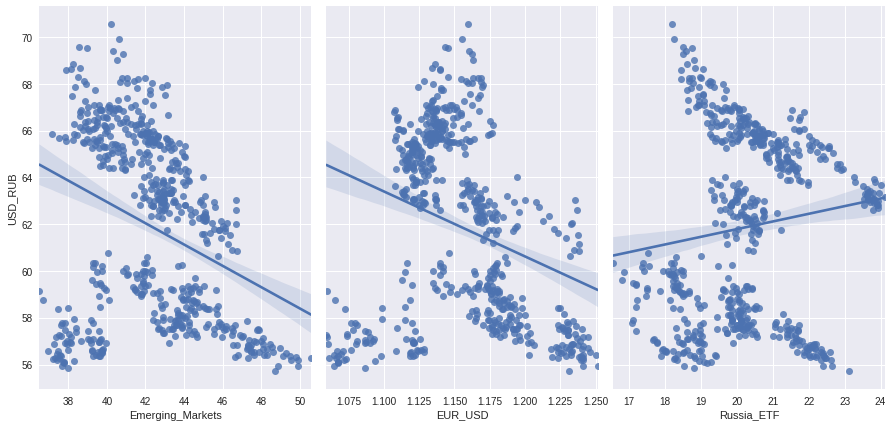

In [9]:
sns.pairplot(main_df, x_vars=['Emerging_Markets','EUR_USD','Russia_ETF'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

## Train/test split

In [10]:
X_train = X[(X.index < int(0.8*len(X)))]
y_train = y[(y.index < int(0.8*len(y)))]

X_test = X[(X.index >= int(0.8*len(X)))]
y_test = y[(y.index >= int(0.8*len(y)))]

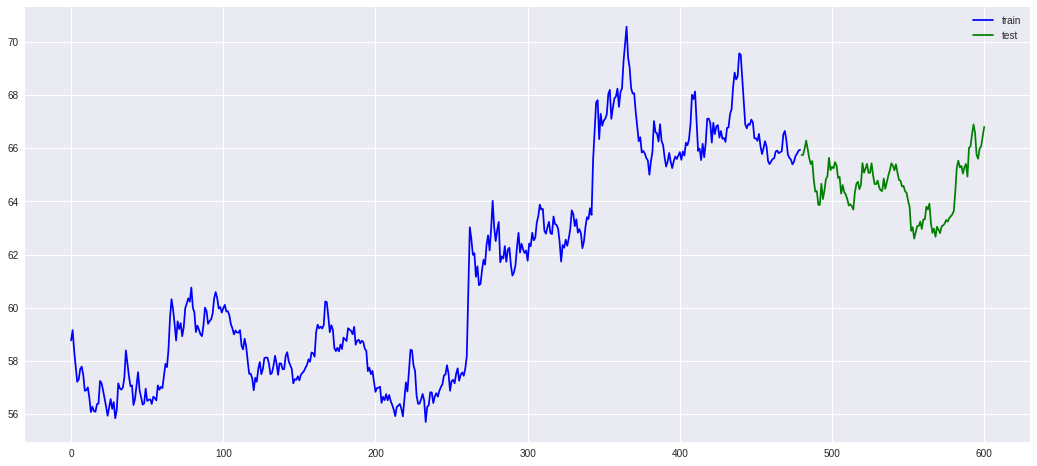

In [11]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(y_train, color='blue', label='train')
plt.plot(y_test, color='green', label='test')
plt.legend()

##Feature-wise normalisation


In [12]:
pipeline = Pipeline([('std_scalar', StandardScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

##Let's try a few basic ML models

In [13]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted).round(3)    
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)         
    print('MAE:', mae)
    print('RMSE:', rmse)    
        
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted).round(3)      
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)           
    return mae,  rmse

In [14]:
model = Ridge(alpha = 100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.573
RMSE: 2.185

Train set evaluation:
MAE: 0.814
RMSE: 0.988


In [15]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,1.573,2.185


In [16]:
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.223
RMSE: 1.652

Train set evaluation:
MAE: 0.112
RMSE: 0.163


In [17]:
results_df_1 = pd.DataFrame(data=[["RandomForestRegressor", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_1, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,1.573,2.185
2,RandomForestRegressor,1.223,1.652


In [20]:
early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),])

model.compile(optimizer=Adam(0.001), loss='mae')

history  = model.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size=10, epochs = 100, callbacks=[early_stopping],verbose=0)

 Minimum validation loss(mae): 0.98


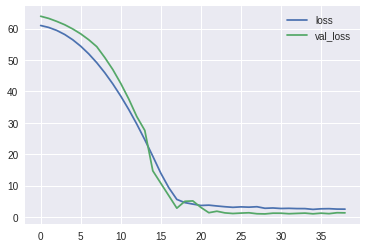

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print(f' Minimum validation loss(mae): {round(history_df.val_loss.min(),3)}')

In [22]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 0.98
RMSE: 1.615

Train set evaluation:
MAE: 0.844
RMSE: 1.052


In [23]:
results_df_1 = pd.DataFrame(data=[["DNN", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_1, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,1.573,2.185
2,RandomForestRegressor,1.223,1.652
3,DNN,0.980,1.615


In [24]:
train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_test, label=y_test)

model = CatBoostRegressor(iterations=2000, learning_rate=0.002, custom_metric=['MAE'])

model.fit(train_pool, eval_set=validation_pool, verbose= 200)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

0:	learn: 4.0181075	test: 3.5336157	best: 3.5336157 (0)	total: 49.1ms	remaining: 1m 38s
200:	learn: 2.8949195	test: 2.6404977	best: 2.6404977 (200)	total: 488ms	remaining: 4.37s
400:	learn: 2.1169685	test: 2.1171912	best: 2.1171912 (400)	total: 913ms	remaining: 3.64s
600:	learn: 1.5859625	test: 1.8285839	best: 1.8285839 (600)	total: 1.34s	remaining: 3.12s
800:	learn: 1.2253551	test: 1.6685893	best: 1.6685893 (800)	total: 1.76s	remaining: 2.63s
1000:	learn: 0.9791703	test: 1.5896429	best: 1.5896429 (1000)	total: 2.19s	remaining: 2.18s
1200:	learn: 0.8107024	test: 1.5521976	best: 1.5521976 (1200)	total: 2.61s	remaining: 1.74s
1400:	learn: 0.6942977	test: 1.5313630	best: 1.5309845 (1397)	total: 3.03s	remaining: 1.29s
1600:	learn: 0.6132533	test: 1.5259841	best: 1.5253282 (1528)	total: 3.45s	remaining: 860ms
1800:	learn: 0.5548929	test: 1.5226304	best: 1.5219579 (1751)	total: 3.89s	remaining: 430ms
1999:	learn: 0.5110612	test: 1.5236294	best: 1.5219579 (1751)	total: 4.31s	remaining: 0us

b

In [25]:
MAE = round(model.best_score_['validation']['MAE'],3)
RMSE =  round(model.best_score_['validation']['RMSE'],3)

results_df_2 = pd.DataFrame(data=[['CatBoost', MAE, RMSE]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,1.573,2.185
2,RandomForestRegressor,1.223,1.652
3,DNN,0.980,1.615
4,CatBoost,0.890,1.522


Since price movements are volatile and the main idea is to be good in evaluating fundamental price MAE metric (Mean Absolute Error) is preferable. CatBoost looks promising and it has a lot of potential for optimization and hyperparameters tuning.  

In [22]:
random_state=42

def catboost_opt(params, random_state=random_state, X=X_train, y=y_train):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate'],
              'l2_leaf_reg': params['l2_leaf_reg']}    
    
    model = CatBoostRegressor(**params, random_seed = random_state)
    model.fit(train_pool, eval_set=validation_pool, verbose= 0)   
    y_pred = model.predict(X_test)
     
    return metrics.mean_absolute_error(y_test, y_pred)

In [23]:
space={'n_estimators': hp.quniform('n_estimators', 500, 3000, 20),
       'max_depth' : hp.quniform('max_depth', 1, 5, 1),
       'learning_rate': hp.loguniform('learning_rate', -7, -1),
       'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10) }

best=fmin(fn = catboost_opt, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 500, # maximum number of iterations         
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
          )

100%|██████████| 500/500 [22:13<00:00,  2.67s/it, best loss: 0.662360108915937]


In [24]:
best

{'l2_leaf_reg': 2.4778906375402743,
 'learning_rate': 0.13276398766866654,
 'max_depth': 4.0,
 'n_estimators': 2180.0}

In [26]:
model = CatBoostRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'], l2_leaf_reg = best['l2_leaf_reg'],  custom_metric=['MAE'])

model.fit(train_pool, eval_set=validation_pool, verbose= 200)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))


0:	learn: 3.5824509	test: 3.1789170	best: 3.1789170 (0)	total: 1.04ms	remaining: 2.26s
200:	learn: 0.2052870	test: 1.0970300	best: 1.0970300 (200)	total: 185ms	remaining: 1.82s
400:	learn: 0.1198330	test: 1.0881828	best: 1.0771892 (315)	total: 367ms	remaining: 1.63s
600:	learn: 0.0784466	test: 1.1098136	best: 1.0771892 (315)	total: 552ms	remaining: 1.45s
800:	learn: 0.0565026	test: 1.1207597	best: 1.0771892 (315)	total: 744ms	remaining: 1.28s
1000:	learn: 0.0428777	test: 1.1306539	best: 1.0771892 (315)	total: 921ms	remaining: 1.08s
1200:	learn: 0.0330152	test: 1.1337992	best: 1.0771892 (315)	total: 1.1s	remaining: 898ms
1400:	learn: 0.0256221	test: 1.1384902	best: 1.0771892 (315)	total: 1.28s	remaining: 714ms
1600:	learn: 0.0205385	test: 1.1385301	best: 1.0771892 (315)	total: 1.47s	remaining: 530ms
1800:	learn: 0.0166974	test: 1.1410485	best: 1.0771892 (315)	total: 1.66s	remaining: 349ms
2000:	learn: 0.0133048	test: 1.1396865	best: 1.0771892 (315)	total: 1.84s	remaining: 165ms
2179:	le

In [32]:
MAE = round(model.best_score_['validation']['MAE'],3)
print(f'Best score\nMAE = {MAE}')

Best score
MAE = 0.662


In [31]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,6,59.224263
1,5,11.369593
2,2,8.252141
3,3,5.527136
4,4,5.487614
5,0,5.476019
6,7,2.672647
7,1,1.990587


Treas_4M and Russia_ETF (US government bonds and Russian stock index) are two most important features

## Some basic quantitative analysis of the results.

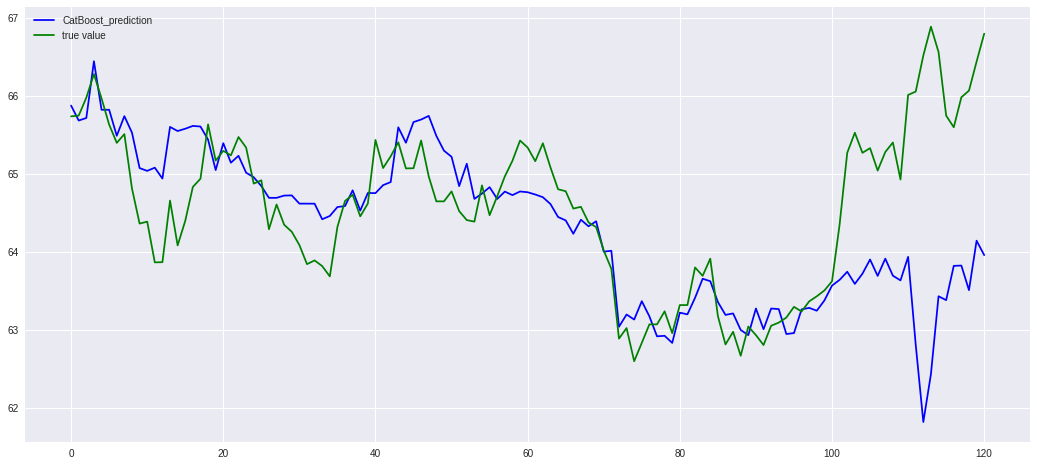

In [49]:
prediction = model.predict(X_test)

fig, ax = plt.subplots(figsize=(18,8))
plt.plot(prediction, color='blue', label='CatBoost_prediction')
plt.plot(np.array(y_test), color='green', label='true value')
plt.legend()

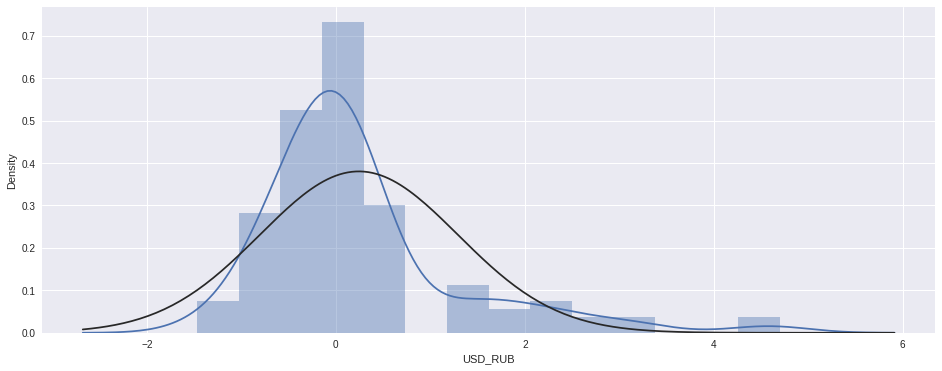

In [55]:
deviation = y_test - prediction
fig = plt.figure(figsize=(16,6))
sns.distplot(deviation, bins=14, fit=norm);

Unlike USD/RUB, prediction error has quite normal (Gaussian) distribution thus Empirical Rule can be applied.  

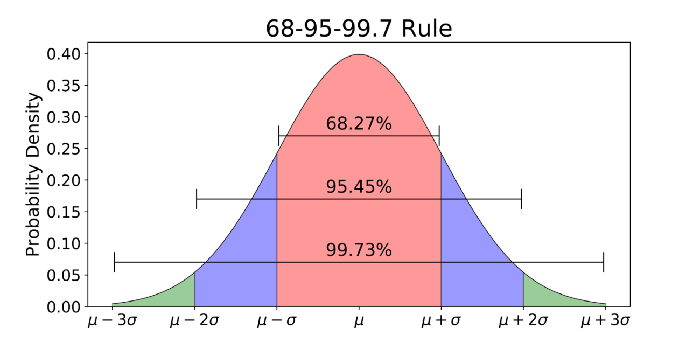

The normal distribution is commonly associated with the 68-95-99.7 rule which you can see in the image above. 68% of the data is within 1 standard deviation (σ) of the mean (μ), 95% of the data is within 2 standard deviations (σ) of the mean (μ), and 99.7% of the data is within 3 standard deviations (σ) of the mean (μ).

In [56]:
USD_mean = round(y.mean(),2)
USD_std =round(y.std(),2)

mean_error = round(deviation.mean(),2)

std_deviation =  round(deviation.std(),2)
relative_mispricing = deviation/std_deviation

Upper_limit = mean_error + 2*std_deviation
Lower_limit = mean_error - 2*std_deviation

print("USD mean value =", USD_mean) # calculated for the all cleaned dataset 
print("USD standard deviation =", USD_std) # calculated for the all cleaned dataset
print("Mean Error =",mean_error) # Mean Error of our prediction calculated for the all cleaned dataset
print("Standard deviation of the error =", std_deviation) # standard deviation of  prediction error calculated for the all cleaned dataset

USD mean value = 61.87
USD standard deviation = 3.88
Mean Error = 0.24
Standard deviation of the error = 1.05


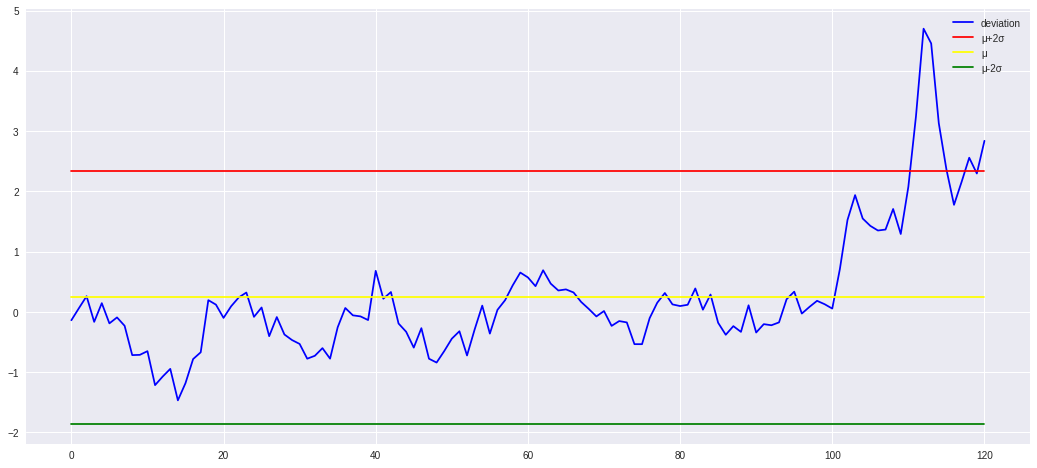

In [62]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(np.array(deviation) , color='blue', label='deviation')
plt.plot(np.full((121, ),Upper_limit), color='red', label='μ+2σ')
plt.plot(np.full((121, ),mean_error), color='yellow', label='μ')
plt.plot(np.full((121, ),Lower_limit), color='green', label='μ-2σ')
plt.legend()

## Wrapping up
Quantitative analysis and statistical approach of assets pricing can be useful and give good results for the purposes of 'fair' baised on underlying fundamentals pricing as well as detection and evaluation of anomalys in market pricing. And even though fundamentals isn't always price movement's main driving force good understanding of them can give some adge.